## Git Repository Link

https://github.com/brynnelisekamp/DSCI-PROJECT

In [5]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(tidyr)
options(repr.matrix.max.rows = 6)

In [2]:
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [16]:
players_no_na <- players %>% drop_na()
players_no_na
players <- players %>% drop_na()

sessions <- sessions %>% drop_na()

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


In [23]:
summary_statistics_players <- players |>
    select(played_hours, Age) |>
    map(mean)
summary_statistics_players

summary_stats_sessions <- sessions|>
    select(original_start_time, original_end_time) |>
    map(mean)
summary_stats_sessions

$played_hours
[1] 5.904639

$Age
[1] 21.13918

$original_start_time
[1] 1.719193e+12

$original_end_time
[1] 1.719196e+12

Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_point()`).”


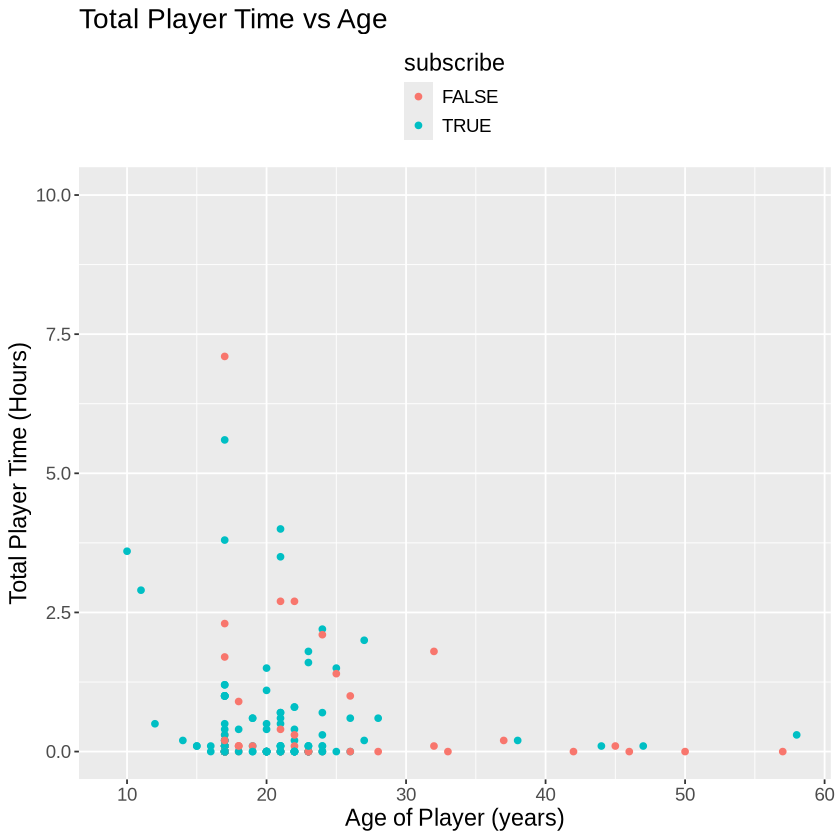

In [39]:
age_vs_hours_plot <- ggplot(players, aes(x = Age, y = played_hours,
                                        color = subscribe)) +
    geom_point() +
    labs(x = "Age of Player (years)", y = "Total Player Time (Hours)", title = "Total Player Time vs Age") +
    theme(text = element_text(size = 14),
            legend.position = "top",
            legend.direction = "vertical") +
    ylim(0, 10)
age_vs_hours_plot

I initially looked at this graph with and without the ylimit. Since some people reported zero hours, the log scale could not be applied. There does seem a relation with age to subscribership, but no obvious ones to time played and subscribership. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


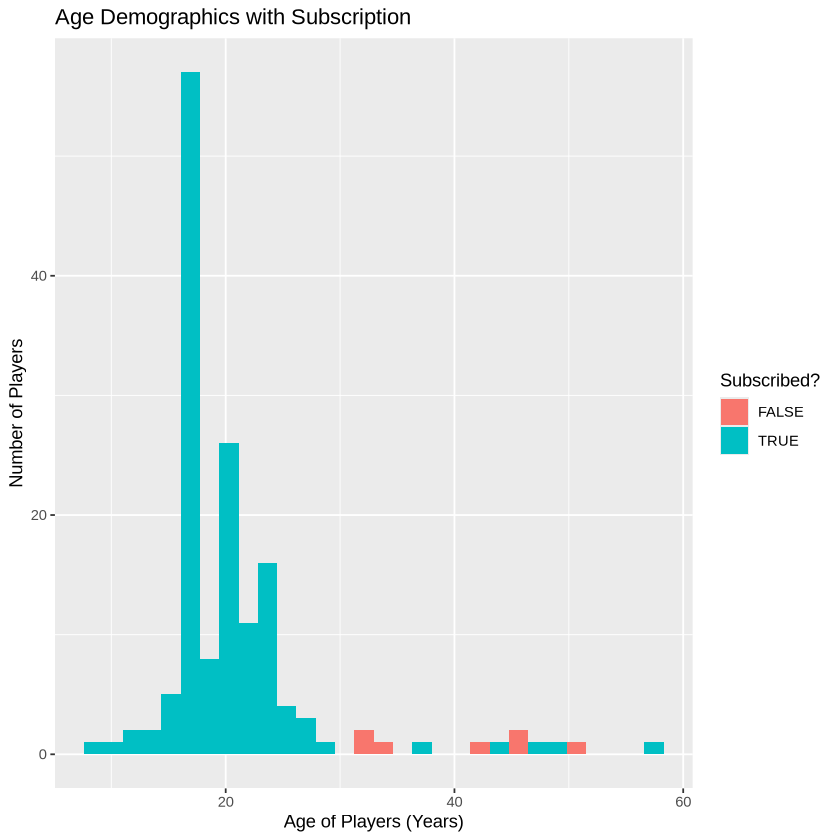

In [50]:
histogram_plot <- ggplot(players, aes(x = Age, fill = as_factor(subscribe))) +
    geom_histogram(position = "identity") +
    labs(x = "Age of Players (Years)", y = "Number of Players", title = "Age Demographics with Subscription",  
         key = "Subscribed?")+
    guides(fill=guide_legend(title="Subscribed?"))
histogram_plot

### Second Plot Observations

We do see a slight increase in those subscribed to the newletter as the age increases, which does confirm that it could be a good classifier to see if they will engage in that manner.

Two datasets will be utilized to understand the use of the MineCraft server by various types of players in order to increase retention and understand the resources necessary. 

#### players.csv:
- 196 observations, each of which represents a different player
- 7 variables
  - Experience:(Character variable) This is a classifier variable, with options of Pro, Veteran, Amateur, Regular, and Beginner
  - Subscribe: (Logical variable) Indicates whether or not the player is subscribed to the newsletter about the game
  - hashedEmail: (Character variable) ID that gives the email of each player encrypted so as to not compromise their private information
  - Name: (Character variable) Gives the name of each player, form of ID
  - Gender: (Character variable) Gives the gender of the player
  - played_hours: (Double variable) Gives the total number of hours a player has played on the server.
    - Average: 5.90 hours
  - Age: (Double variable) Age of the player
    - Average: 21.14 years old
- This data has some NA for some variables, and it may be beneficial to ignore these using na.rm = TRUE, with the caveat it may lead to less data being used for the training, which could impact our ability to develop a good model.
  - Update: Wrangling has found that this is only the case for two observations. Because of this, I will drop the observations with NA for an observation, in order to have full complete data. 

#### session.csv:
- 1535 observations, indicating a player session
- 5 variables
  - hashedEmail (Character variable) ID that gives the email of each player encrypted so as to not compromise their private information
  - start_time: (Character variable) Lists the date and time that a session was started. Could be interpreted as untidy data due to multiple variables in one cell.
  - stop_time: (Character variable) Lists the date and time that a session was finished. Could be interpreted as untidy data due to multiple variables in one cell.
  - original_start_time: (Double variable): Likely the start time since the Minecraft server was started.
  - original_end_time: (Double variable) Likely the end time since the Minecraft server was started
- This data has some NA for some variables, and it may be beneficial to ignore these using na.rm = TRUE, with the caveat it may lead to less data being used for the training, which could impact our ability to develop a good model.

### Question:
Can we use age and total played hours to determine if a player will subscribe to the newsletter?

To answer this question, I will perform a k-nearest neighbors classification to the dataset, using the age and total played hours as the predictors, and age as the prediction. 


### Methods and Plan:
- This method is appropriate because the variables age and total played hours are a numeric variable that can classify and mark the demographics on someone, and the "subscribed" variable is a good classifier.
- This does assume however, that these variables make sense to affect a person's decision on whether or not to subscribe to a newsletter. To me, it makes sense that someone who grew up with newspapers and prints woiuld appreciate a newsletter, but someone younger might not. Also, if you play more hours, you're likely a bigger fan and would appreciate updates on the project. However, these are assymptions.
- The weaknesses may be in the amount of data we have. Since we only have the 196 observations for players, we might be limited in how accurate our data set is able to be.
- I'm going to compare my model by aiming for a high accuracy, greater than 80%.
- To process the data, the columns age and hours will need to be standardized, and I want to perform cross validation with a variety of k-nearest neighbors in order to make sure the one best suited for the model will be selected. I will split initially, using a 75% training, 25% testing split, and then further split in order to make the vfolds and find the best k-nearest neighbors.
- The sessions.csv will not be wrangled, as it is not relevant to my question.